In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import torch
from torch.utils.data import TensorDataset, Dataset

In [2]:
# mydatasets.py

import numpy as np
import pandas as pd
from scipy import sparse
import torch
from torch.utils.data import TensorDataset, Dataset
from sklearn.preprocessing import StandardScaler


def load_seizure_dataset(path, model_type):
    """
    :param path: a path to the seizure data CSV file
    :return dataset: a TensorDataset consists of a data Tensor and a target Tensor
    """
    # TODO: Read a csv file from path.
    # TODO: Please refer to the header of the file to locate X and y.
    # TODO: y in the raw data is ranging from 1 to 5. Change it to be from 0 to 4.
    # TODO: Remove the header of CSV file of course.
    # TODO: Do Not change the order of rows.
    # TODO: You can use Pandas if you want to.

    df = pd.read_csv(path)

    if model_type == 'MLP':
        raw = df.loc[:, "X1":"X178"].values
        scaler = StandardScaler()
        scaler.fit(raw)
        data = scaler.transform(raw)
        target = df['y'].values - 1
        dataset = TensorDataset(torch.from_numpy(data.astype('float32')), torch.from_numpy(target.astype('long')))
    elif model_type == 'CNN':
        raw = df.loc[:, "X1":"X178"].values
        scaler = StandardScaler()
        scaler.fit(raw)
        data = scaler.transform(raw)
        target = df['y'].values - 1
        dataset = TensorDataset(torch.from_numpy(data.astype('float32')).unsqueeze(1), torch.from_numpy(target.astype('long')))
    elif model_type == 'RNN':
        data = torch.zeros((2, 2))
        target = torch.zeros(2)
        dataset = TensorDataset(data, target)
    else:
        raise AssertionError("Wrong Model Type!")
    return dataset

In [3]:
# mymodels.py

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F


class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.hidden1 = nn.Linear(178, 16)
        self.hidden2 = nn.Linear(64, 16)
        self.out = nn.Linear(16, 5)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x


class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv1_bn = nn.BatchNorm1d(6)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv2_bn = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(in_features=16*41, out_features=128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 5)
        
    def forward(self, x):
#         x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
#         x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
#         x = x.view(-1, 16*41) # Flatten the output to a vector feed into dense layer
#         x = F.relu(self.fc1_bn(self.fc1(x)))
#         x = self.fc2(x)

        x = self.conv1_bn(self.pool(F.relu(self.conv1(x))))
        x = self.conv2_bn(self.pool(F.relu(self.conv2(x))))
        x = x.view(-1, 16*41) # Flatten the output to a vector feed into dense layer
        x = self.fc1_bn(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# class MyRNN(nn.Module):
# def __init__(self):
#     super(MyRNN, self).__init__()

# def forward(self, x):
#     return x


# class MyVariableRNN(nn.Module):
# def __init__(self, dim_input):
#     super(MyVariableRNN, self).__init__()
#     # You may use the input argument 'dim_input', which is basically the number of features

# def forward(self, input_tuple):
#     # HINT: Following two methods might be useful
#     # 'pack_padded_sequence' and 'pad_packed_sequence' from torch.nn.utils.rnn

#     seqs, lengths = input_tuple

#     return seqs

In [4]:
# plots.py

import matplotlib.pyplot as plt
# TODO: You can use other packages if you want, e.g., Numpy, Scikit-learn, etc.
from sklearn.metrics import confusion_matrix


def plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    # TODO: Make plots for loss curves and accuracy curves.
    # TODO: You do not have to return the plots.
    # TODO: You can save plots as files by codes here or an interactive way according to your preference.
    
    # Loss curve
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()
    
    # Accuracy Curve
    plt.plot(train_accuracies, label='Train')
    plt.plot(valid_accuracies, label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()
    pass


def plot_confusion_matrix(results, class_names):
    # TODO: Make a confusion matrix plot.
    # TODO: You do not have to return the plots.
    # TODO: You can save plots as files by codes here or an interactive way according to your preference.
    y_true = list(zip(*test_results))[0]
    y_pred = list(zip(*test_results))[1]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    cmap=plt.cm.Blues
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    


/Users/nabeelnauman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nabeelnauman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nabeelnauman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nabeelnauman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nabeelnauman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validati

Epoch: [0][0/252]	Time 0.167 (0.167)	Data 0.038 (0.038)	Loss 1.6115 (1.6115)	Accuracy 21.000 (21.000)
Epoch: [0][10/252]	Time 0.007 (0.022)	Data 0.001 (0.004)	Loss 1.1492 (1.3066)	Accuracy 50.000 (41.000)
Epoch: [0][20/252]	Time 0.007 (0.015)	Data 0.000 (0.002)	Loss 1.2723 (1.2590)	Accuracy 37.000 (44.714)
Epoch: [0][30/252]	Time 0.009 (0.013)	Data 0.001 (0.002)	Loss 1.3199 (1.2427)	Accuracy 37.000 (45.226)
Epoch: [0][40/252]	Time 0.007 (0.011)	Data 0.000 (0.001)	Loss 1.0709 (1.2133)	Accuracy 43.000 (46.171)
Epoch: [0][50/252]	Time 0.007 (0.011)	Data 0.001 (0.001)	Loss 0.9653 (1.1920)	Accuracy 62.000 (47.941)
Epoch: [0][60/252]	Time 0.008 (0.010)	Data 0.001 (0.001)	Loss 1.0459 (1.1762)	Accuracy 56.000 (48.492)
Epoch: [0][70/252]	Time 0.007 (0.010)	Data 0.001 (0.001)	Loss 1.0035 (1.1507)	Accuracy 40.000 (49.746)
Epoch: [0][80/252]	Time 0.007 (0.009)	Data 0.001 (0.001)	Loss 1.0096 (1.1285)	Accuracy 56.000 (51.037)
Epoch: [0][90/252]	Time 0.008 (0.009)	Data 0.001 (0.001)	Loss 0.8632 (1.11

/Users/nabeelnauman/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MyCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/252]	Time 0.044 (0.044)	Data 0.027 (0.027)	Loss 1.1456 (1.1456)	Accuracy 56.000 (56.000)
Epoch: [1][10/252]	Time 0.007 (0.012)	Data 0.000 (0.003)	Loss 0.7746 (0.7881)	Accuracy 65.000 (65.545)
Epoch: [1][20/252]	Time 0.007 (0.010)	Data 0.001 (0.002)	Loss 0.7270 (0.7481)	Accuracy 65.000 (66.810)
Epoch: [1][30/252]	Time 0.007 (0.009)	Data 0.001 (0.002)	Loss 0.7967 (0.7712)	Accuracy 71.000 (65.129)
Epoch: [1][40/252]	Time 0.008 (0.009)	Data 0.001 (0.001)	Loss 0.7660 (0.7498)	Accuracy 68.000 (66.488)
Epoch: [1][50/252]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 0.9640 (0.7702)	Accuracy 65.000 (65.961)
Epoch: [1][60/252]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 0.6305 (0.7688)	Accuracy 68.000 (65.279)
Epoch: [1][70/252]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 0.9277 (0.7697)	Accuracy 46.000 (65.042)
Epoch: [1][80/252]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 0.9374 (0.7718)	Accuracy 53.000 (64.914)
Epoch: [1][90/252]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 0.6804 (0.78

Epoch: [3][220/252]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 0.5807 (0.6136)	Accuracy 68.000 (71.719)
Epoch: [3][230/252]	Time 0.009 (0.008)	Data 0.001 (0.001)	Loss 0.7869 (0.6150)	Accuracy 56.000 (71.541)
Epoch: [3][240/252]	Time 0.007 (0.008)	Data 0.001 (0.001)	Loss 0.8595 (0.6177)	Accuracy 53.000 (71.340)
Epoch: [3][250/252]	Time 0.007 (0.008)	Data 0.001 (0.001)	Loss 0.5961 (0.6191)	Accuracy 84.000 (71.215)
Test: [0/36]	Time 0.036 (0.036)	Loss 0.6088 (0.6088)	Accuracy 84.000 (84.000)
Test: [10/36]	Time 0.003 (0.006)	Loss 0.6101 (0.6507)	Accuracy 75.000 (72.000)
Test: [20/36]	Time 0.003 (0.005)	Loss 0.5220 (0.5968)	Accuracy 84.000 (74.476)
Test: [30/36]	Time 0.004 (0.004)	Loss 0.5368 (0.6002)	Accuracy 78.000 (73.677)


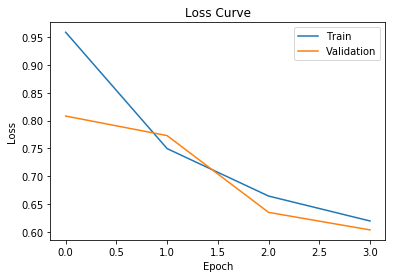

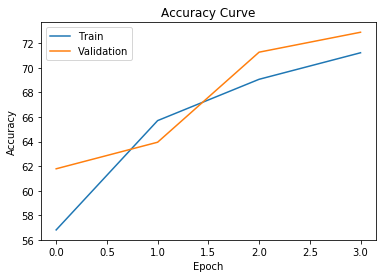

Test: [0/36]	Time 0.026 (0.026)	Loss 0.5325 (0.5325)	Accuracy 68.000 (68.000)
Test: [10/36]	Time 0.002 (0.005)	Loss 0.4949 (0.5985)	Accuracy 71.000 (70.545)
Test: [20/36]	Time 0.002 (0.011)	Loss 0.6319 (0.5879)	Accuracy 65.000 (71.286)
Test: [30/36]	Time 0.003 (0.008)	Loss 0.4984 (0.6003)	Accuracy 81.000 (71.548)


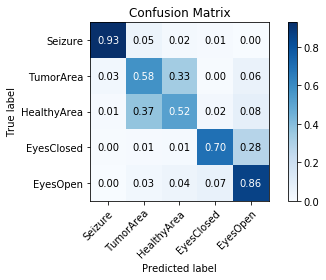

In [5]:
# train_seizure.py

import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

# from mydatasets import load_seizure_dataset
from utils import train, evaluate
# from plots import plot_learning_curves, plot_confusion_matrix
# from mymodels import MyMLP, MyCNN, MyRNN

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# Set a correct path to the seizure data file you downloaded
PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# Path for saving model
PATH_OUTPUT = "../output/seizure/"
os.makedirs(PATH_OUTPUT, exist_ok=True)

# Some parameters
MODEL_TYPE = 'CNN'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 4
BATCH_SIZE = 32
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 2  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

train_dataset = load_seizure_dataset(PATH_TRAIN_FILE, MODEL_TYPE)
valid_dataset = load_seizure_dataset(PATH_VALID_FILE, MODEL_TYPE)
test_dataset = load_seizure_dataset(PATH_TEST_FILE, MODEL_TYPE)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


if MODEL_TYPE == 'MLP':
    model = MyMLP()
    save_file = 'MyMLP.pth'
elif MODEL_TYPE == 'CNN':
    model = MyCNN()
    save_file = 'MyCNN.pth'
elif MODEL_TYPE == 'RNN':
    model = MyRNN()
    save_file = 'MyRNN.pth'
else:
    raise AssertionError("Wrong Model Type!")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
    if is_best:
        best_val_acc = valid_accuracy
        torch.save(model, os.path.join(PATH_OUTPUT, save_file))

plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(os.path.join(PATH_OUTPUT, save_file))
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)

class_names = ['Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen']
plot_confusion_matrix(test_results, class_names)


In [6]:
from torchvision import models
from torchsummary import summary


summary(model, (1, 178))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 6, 174]              36
         MaxPool1d-2                [-1, 6, 87]               0
       BatchNorm1d-3                [-1, 6, 87]              12
            Conv1d-4               [-1, 16, 83]             496
         MaxPool1d-5               [-1, 16, 41]               0
       BatchNorm1d-6               [-1, 16, 41]              32
            Linear-7                  [-1, 128]          84,096
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                    [-1, 5]             645
Total params: 85,573
Trainable params: 85,573
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.33
Estimated Total Size (MB): 0.37
---------------------------------------------

In [7]:
dataiter = iter(train_loader)
X, y = dataiter.next()

print(X)
print(y)

tensor([[[-0.4939, -0.2729, -0.2008,  ..., -5.8408, -4.4689, -2.8449]],

        [[-0.4092, -0.3572, -0.2311,  ..., -0.6300, -1.1000, -1.1669]],

        [[ 0.0203,  0.0221, -0.0372,  ..., -0.2905, -0.4350, -0.4833]],

        ...,

        [[ 0.5648,  0.1786, -0.2432,  ...,  0.1243, -0.0335, -0.3714]],

        [[ 0.2804,  0.2750,  0.3202,  ...,  0.0615,  0.1547,  0.2998]],

        [[ 0.0687, -0.0501,  0.0355,  ...,  0.2249,  0.1296,  0.0201]]])
tensor([0, 3, 1, 4, 1, 4, 0, 2, 3, 3, 3, 2, 1, 1, 0, 4, 1, 2, 4, 3, 0, 2, 0, 3,
        0, 0, 2, 2, 4, 3, 4, 4])


In [8]:
X.shape

torch.Size([32, 1, 178])

In [9]:
model

MyCNN(
  (conv1): Conv1d(1, 6, kernel_size=(5,), stride=(1,))
  (conv1_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 16, kernel_size=(5,), stride=(1,))
  (conv2_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=656, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)